# Personalized Medicine: Redefining Cancer Treatment
In this competition you will develop algorithms to classify genetic mutations based on clinical evidence (text). There are nine different classes a genetic mutation can be classified on.The aim of the project is predict which class of cancer is belong to based on doctor report. This is natural language proccesing project.

**Steps**
1. [Importing library](#Importing-library)
2. [Read data set](#Read-data-set)
3. [Explore data set](#Explore-data-set)
4. [Univariate analysis](#Univariate-analysis)
5. [Cleaning of data](#Cleaning-of-data)
6. [Determine lenght of text](#Determine-lenght-of-text)
7. [Bag of word](#Bag-of-word)
8. [Converting-to-categorical-variable](#Converting to categorical variable)
9. [Feature Scaling](#Feature-Scaling)
10. [Light gbm](#Light-gbm)
11. [KFold corss validate model](#KFold-corss-validate-model)
12. [Predict for unseen data set](#Predict-for-unseen-data-set)

## Importing library

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix,mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
import lightgbm as lgb
%matplotlib inline

   ## Read data set

In [4]:
path = ''
#path = '../input/'
train = pd.read_csv(path+'training_variants')
test = pd.read_csv(path+'stage2_test_variants.csv')

trainx = pd.read_csv(path+'training_text',sep = '\|\|', engine= 'python', header=None, 
                     skiprows=1, names=["ID","Text"])
testx = pd.read_csv(path+'stage2_test_text.csv',sep = '\|\|', engine= 'python', header=None, 
                     skiprows=1, names=["ID","Text"])

train = pd.merge(train, trainx, how = 'left', on = 'ID').fillna('')
test = pd.merge(test, testx, how = 'left', on = 'ID').fillna('')

Number of rows and columns in the data set (3321, 2)
Number of rows and columns in the data set (5668, 2)


## Explore data set

In [6]:
train_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
test_df.head()

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 6 columns):
ID             3321 non-null int64
Gene           3321 non-null object
Variation      3321 non-null object
Class          3321 non-null int64
Text           3321 non-null object
text_length    3321 non-null int64
dtypes: int64(3), object(3)
memory usage: 341.6+ KB


## Univariate analysis

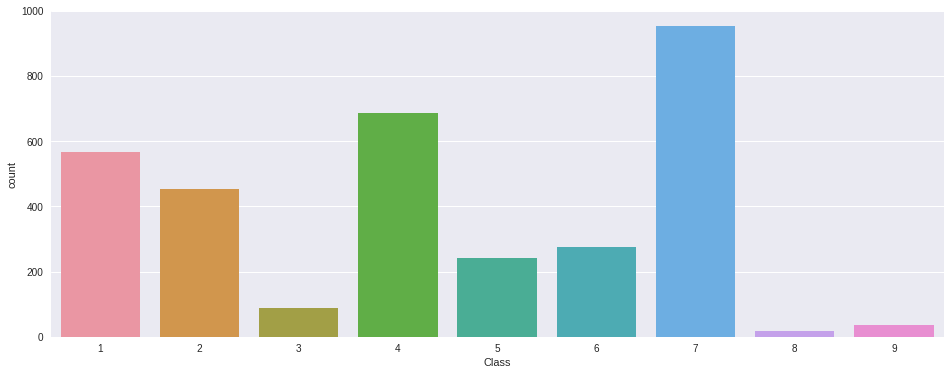

In [9]:
plt.figure(figsize=(16,6))
sns.countplot(train['Class']);

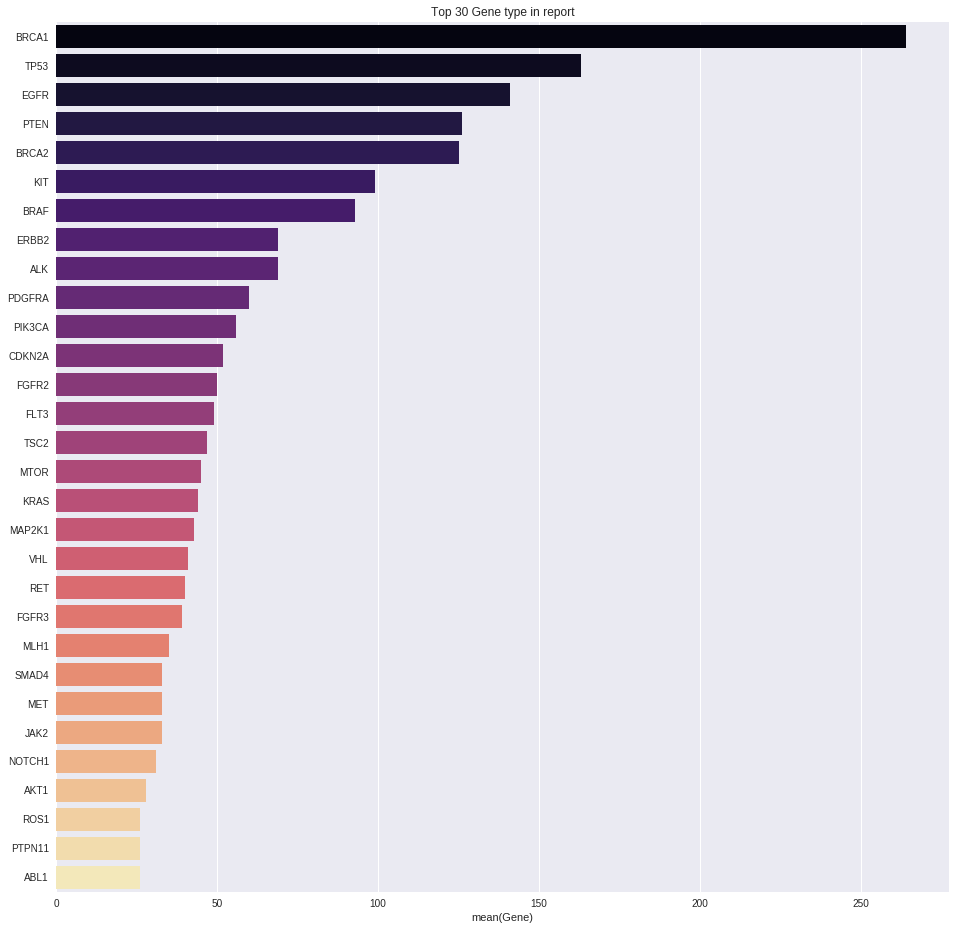

In [35]:
cnt = train['Gene'].value_counts().to_frame()[0:30]

plt.figure(figsize=(16,16))
sns.barplot(cnt['Gene'],cnt.index,palette='magma')
plt.title('Top 30 Gene type in report');

BRCA1 is most frequent gene in the disease

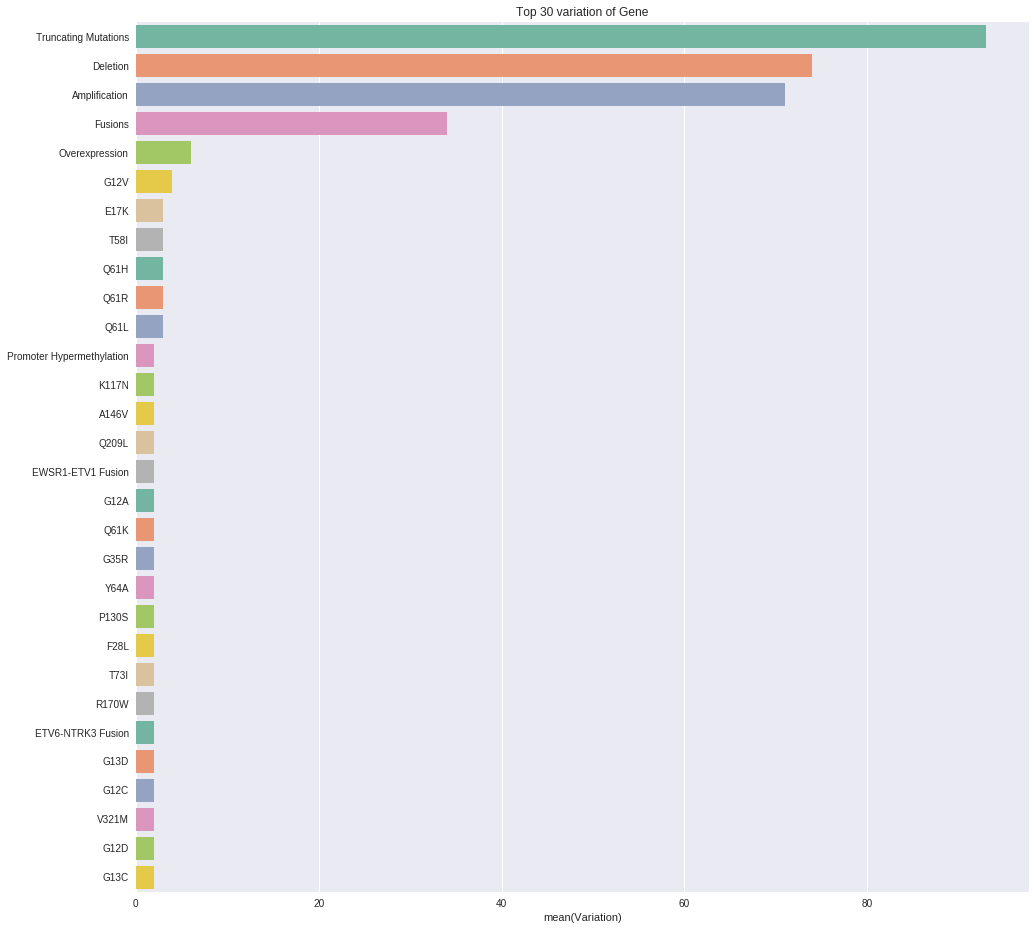

In [20]:
cnt = train['Variation'].value_counts().to_frame()[:30]
plt.figure(figsize=(16,16))
sns.barplot(cnt['Variation'],cnt.index,palette='Set2')
plt.title('Top 30 variation of Gene')

## Cleaning of data

In [28]:
def cleantext(train,):
    corpus = []
    for i in range(0,train.shape[0]):
        review = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]"," ",train['Text'][i])
        review = review.lower().split()
        ps = PorterStemmer()
        review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
    
    return corpus

In [ ]:
corp_train = cleantext(train)
corp_test = cleantext(test)

## Determine lenght of text

In [33]:
def textlen(df):    
    df['Text_no_word']= df['Text'].apply(lambda x: len(str(x).split()))
    df['Text_no_word'] = df['Text'].apply(lambda x: len(str(x)))
    return df

train = textlen(corp_train)
test = textlen(corp_test)

NameError: name 'corp_train' is not defined

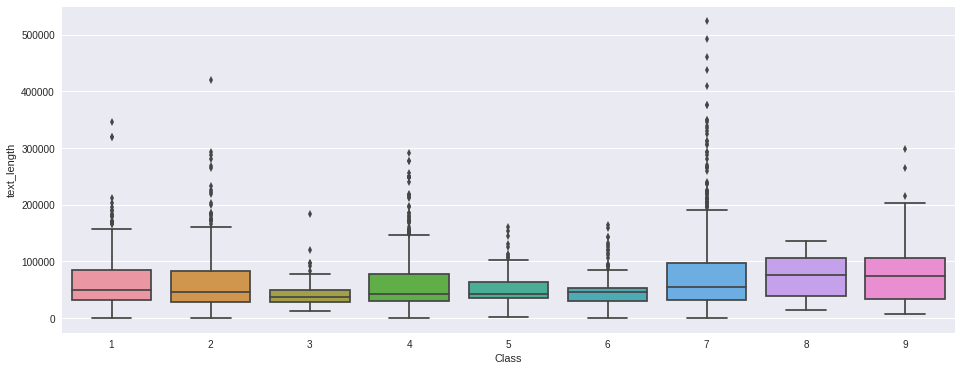

In [19]:
plt.figure(figsize=(16,6))
sns.boxplot(x='Class',y='text_length',data=train);

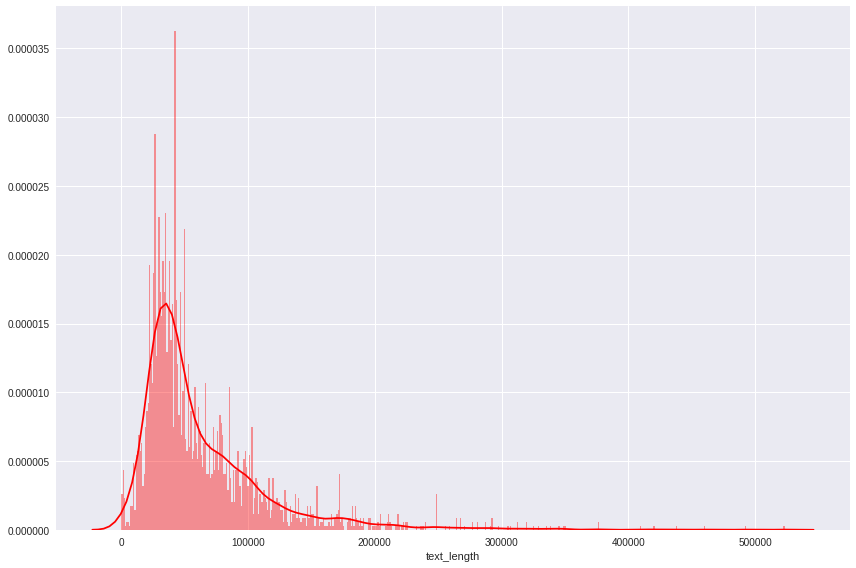

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(train['Text_no_char'],bins=500,color='r')
plt.tight_layout();

## Bag of word

In [35]:
tfidf = TfidfVectorizer(min_df=1, max_features=1600, strip_accents='unicode',lowercase =False,
 analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), use_idf=True, 
 smooth_idf=True, sublinear_tf=True, stop_words = 'english')

In [ ]:
train1 = train
train1['Text'] = corp_train
test1=test
test1['Text'] = corp_test
X_train = tfidf.fit_transform(train1['Text']).toarray()
print(X_train)
X_test = tfidf.fit_transform(test['Text']).toarray()

## Converting to categorical variable

In [85]:
def encoding(df,col):
    le = LabelEncoder()
    for i in col:
        df[i] = le.fit_transform(df[i])
train.columns
col = ['Gene', 'Variation', 'Class']
encoding(train,col)
encoding(test,['Gene', 'Variation'])

In [88]:
X_train = pd.DataFrame(X_train)
X_train = X_train.join(train[['Gene', 'Variation', 'Text_no_word','Text_no_char']]) 
X_test = pd.DataFrame(X_test)
X_test = X_test.join(test[['Gene', 'Variation', 'Text_no_word','Text_no_char']])

AttributeError: module 'nltk' has no attribute 'batch_ne_chunk'

## Feature Scaling

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
y_train = train['Class']

## Light gbm 

In [ ]:
def runLgb(Xtr,Xvl,ytr,yvl,test,num_rounds=10,max_depth=10,eta=0.5,subsample=0.8,
           colsample=0.8,min_child_weight=1,early_stopping_rounds=50,seeds_val=2017):
    
    param = {'objective':'multiclass',
             'num_class':9,
             'learning_rate':eta,
             'metric':{'multi_logloss'},
             'max_depth':max_depth,
             'min_child_weight':min_child_weight,
             'bagging_fraction':subsample,
             'feature_fraction':colsample,
             'bagging_seed':seeds_val,
             'verbose':10,
             'nthread':-1}
    lgtrain = lgb.Dataset(Xtr,label=ytr)
    lgval = lgb.Dataset(Xvl,label=yvl)
    model = lgb.train(param,lgtrain,num_rounds,valid_sets=lgval,
                      early_stopping_rounds=early_stopping_rounds,verbose_eval=20)
    pred_val = model.predict_proba(Xvl,num_iteration = model.best_iteration)
    pred_test = model.predict_proba(test,num_iteration=model.best_iteration)
    return pred_test,pred_val,model


## KFold corss validate model

In [ ]:
kf = KFold(n_splits=10,random_state=111,shuffle=True)
cv_score = []
pred_test_full=0

for train_index,test_index in kf.split(X_train):
    Xtr,Xvl = X_train[train_index],X_train[test_index]
    ytr,yvl = y_train[train_index],y_train[test_index]
    
    pred_test,pred_val,model = runLgb(Xtr,Xvl,ytr,yvl,X_test,num_rounds=10,max_depth=3,
                            eta=0.8,)
    pred_test_full +=pred_test
    cv_score.append(np.sqrt(mean_squared_error(yvl,pred_val)))


## Predict for unseen data set

In [ ]:
y=pd.DataFrame(y_rfc)
#np.mean(y_pred==y_train)

submit = pd.DataFrame(test.ID)
submit = submit.join(pd.DataFrame(y_rfc))
submit.columns = ['ID', 'class1','class2','class3','class4','class5','class6','class7','class8','class9']
submit.to_csv('submission.csv', index=False)